# Part 1: Data
Create synthetic multi-variate Gaussian data using parameters I chose

In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
m = 1
n = 500
d = 1
w = [1, 3]
μ = [-9, 4]
σ = [1, 2]


In [3]:
def generate_mixture_of_gaussians(n_samples, means, stds, weights):
    n_components = len(means)
    assert len(stds) == n_components and len(weights) == n_components
    data = []
    for _ in range(n_samples):
        component = np.random.choice(n_components, p=weights)
        sample = np.random.normal(means[component], stds[component])
        data.append([sample])
    return torch.tensor(data)

In [4]:
data = generate_mixture_of_gaussians(n, μ, σ, w/np.sum(w))

In [5]:
data[:10]

tensor([[ 0.2266],
        [-7.2262],
        [ 3.9550],
        [ 6.8388],
        [-9.4323],
        [ 4.7875],
        [-9.1877],
        [-9.9931],
        [ 2.4681],
        [-9.1091]])

In [6]:
print(data[:10])
print(data.shape)

tensor([[ 0.2266],
        [-7.2262],
        [ 3.9550],
        [ 6.8388],
        [-9.4323],
        [ 4.7875],
        [-9.1877],
        [-9.9931],
        [ 2.4681],
        [-9.1091]])
torch.Size([500, 1])


In [7]:
train_dataloader = DataLoader(data, batch_size=32, shuffle=True)

# Part 2: Models

## Part 2.1: VAE

## Part 2.2: Score Matching
Match scores with a NN with loss
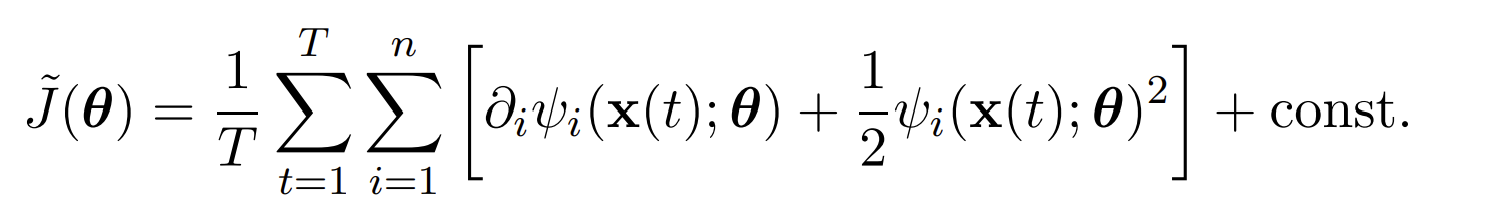 
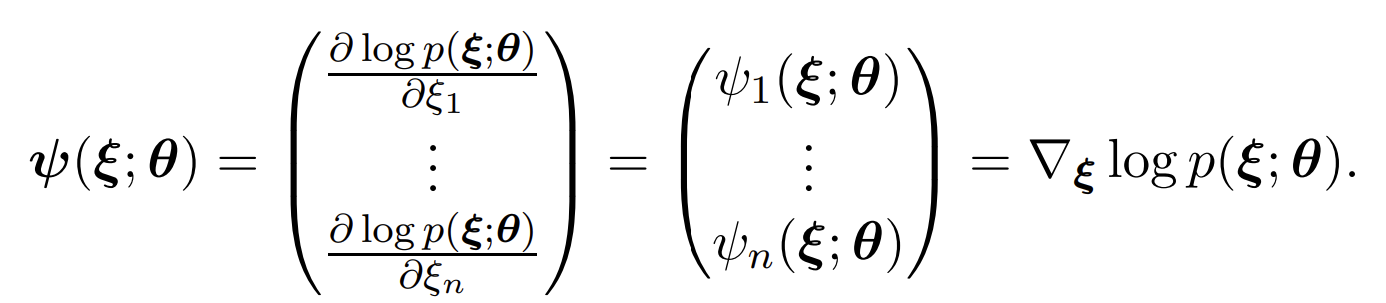

### Part 2.21: Model

In [8]:
def score_matching_loss(model, X):
    loss = None
    for x in X:
        x.requires_grad_(True)
        logp = torch.log(model(x))
        logp.requires_grad_(True)
        ψ = torch.autograd.grad(logp, x, create_graph=True)[0][0]
        ψ.requires_grad_(True)
        ψ2 = torch.autograd.grad(ψ, x, create_graph=True, retain_graph=True)[0][0]
        if loss is None:
            loss = ψ2 + .5 * ψ * ψ
        else:
            loss += ψ2 + .5 * ψ * ψ
    return loss

epoch = 0, loss = -0.0562


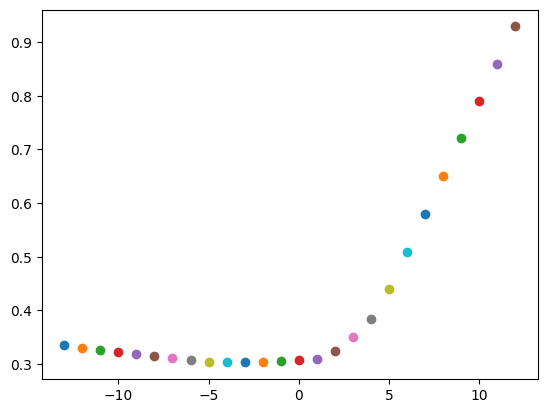

epoch = 5, loss = -30.4626


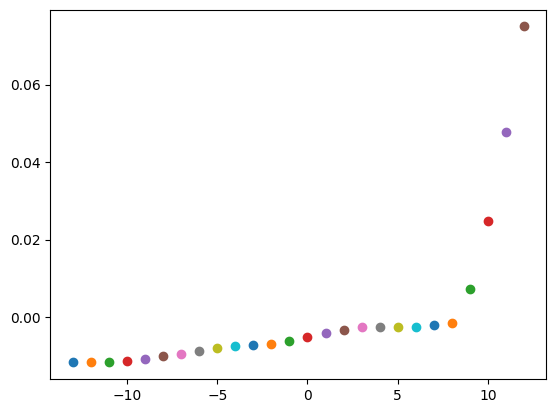

In [13]:
class ScoreMatcher(nn.Module):
    def __init__(self):
        super(ScoreMatcher, self).__init__()
        hidden_layers = [nn.Linear(10, 10), nn.ReLU()]*5
        self.net = nn.Sequential(
            nn.Linear(d, 10),
            *hidden_layers,
            nn.Linear(10, d),
        )

    def forward(self, x):
        return self.net(x)

model = ScoreMatcher()
optimizer = optim.Adam(model.parameters(), lr=.001)

num_epochs = 10

opt = (2000, None)
for epoch in range(num_epochs):
    avg_loss = 0
    for X in train_dataloader:
        output = model(X)
        loss = score_matching_loss(model, X)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss /= len(train_dataloader)
    opt = min(opt, (avg_loss, model))
    if epoch%5==0:
        print(f'epoch = {epoch}, loss = {avg_loss:.4f}')
        for v in range(-13, 13, 1):
            # print(v, float(model(torch.tensor([float(v)]))))
            plt.scatter(v, float(model(torch.tensor([float(v)]))))
        plt.show()
model_opt = opt[1]

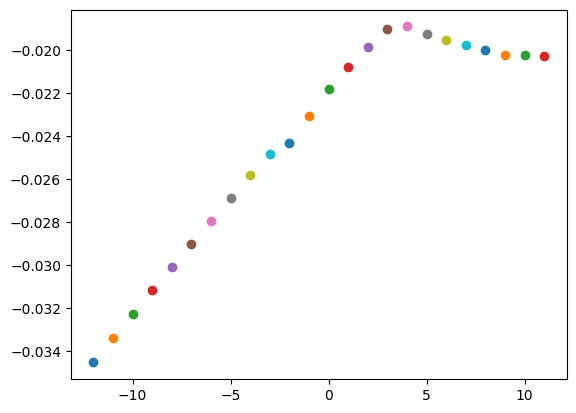

In [32]:
for v in range(-12, 12, 1):
    # print(v, float(model(torch.tensor([float(v)]))))
    plt.scatter(v, float(model_opt(torch.tensor([float(v)]))))
plt.show()

In [11]:
model.mu

AttributeError: 'ScoreMatcher' object has no attribute 'mu'

### Part 2.22: Sample

In [22]:
step_size = 0.1
num_steps = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
def sample_langevin_dynamics(model, n):
    X = torch.randn(n, d)
    for _ in range(num_steps):
        X.requires_grad_(True)
        scores = torch.log(model(X))
        # print(scores[:10])
        grad = torch.autograd.grad(scores, X, grad_outputs=torch.ones_like(scores))[0]
        # print(grad)
        X = X + step_size  * grad + torch.randn(n, d) * sqrt(2 * step_size)
        X = X.detach()
    return X

(array([  1.,   1.,   1.,   9.,  10.,  37.,  68., 109., 121., 162., 131.,
        128., 109.,  60.,  32.,  11.,   7.,   3.]),
 array([-7.02127314, -6.32844067, -5.63560867, -4.94277668, -4.24994421,
        -3.55711198, -2.86427975, -2.17144752, -1.47861528, -0.78578305,
        -0.09295082,  0.59988141,  1.29271364,  1.98554587,  2.67837811,
         3.37121034,  4.06404257,  4.75687504,  5.44970703]),
 <BarContainer object of 18 artists>)

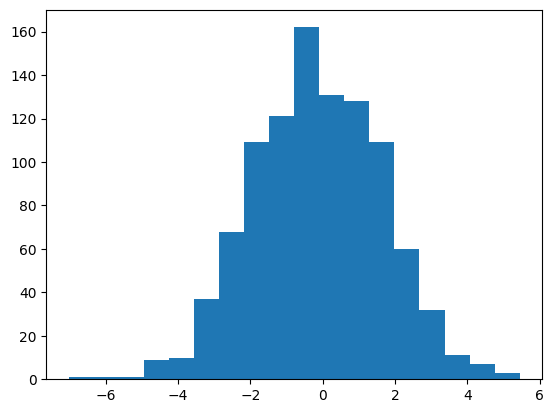

In [31]:
model_opt = opt[1]
sm_data = sample_langevin_dynamics(model_opt, 1000).detach()
plt.hist(sm_data.squeeze(1), bins=18)

(array([ 4., 10.,  5.,  2.,  0.,  0.,  0.,  0.,  1.,  1.,  2., 11., 10.,
        16., 17.,  6.,  9.,  5.,  0.,  1.]),
 array([-10.79042912,  -9.72504139,  -8.65965462,  -7.59426689,
         -6.52887964,  -5.46349239,  -4.39810467,  -3.33271742,
         -2.26732993,  -1.20194256,  -0.13655519,   0.92883217,
          1.99421954,   3.05960703,   4.12499428,   5.19038153,
          6.25576925,   7.3211565 ,   8.38654423,   9.451931  ,
         10.51731873]),
 <BarContainer object of 20 artists>)

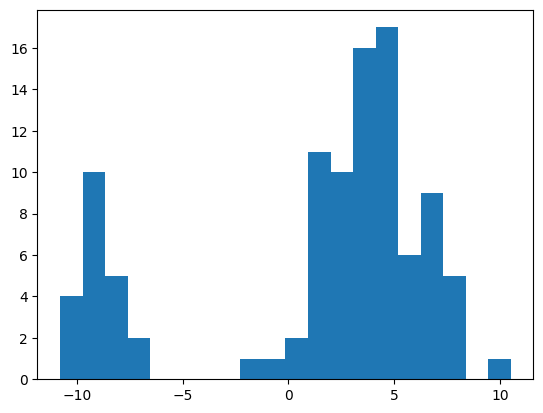

In [ ]:
plt.hist(data.squeeze(1), bins=20)